In [30]:
import torch 
import os
import numpy as np
import umap
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import xgboost as xgb

from FeatureExtraction.ConvolutionalAE import ConvAE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

##  Load data 

In [2]:
cwd = os.getcwd()
annotation_file = os.path.join(cwd, "data", "clinical_annotation.csv")

In [3]:
df_ann = pd.read_csv(annotation_file)
df_ann.drop("Unnamed: 0", axis=1, inplace=True)

# compute age 
def compute_age(x):
    year = int(x[-4:])
    return 2024 - year
    
df_ann["age"] = df_ann.DOB.apply(compute_age)
df_ann.drop("DOB", axis=1, inplace=True)

#encode gender
df_ann["GENDER"] = df_ann["GENDER"].replace('f', "F")
label_encoder = LabelEncoder()
df_ann['GENDER'] = label_encoder.fit_transform(df_ann['GENDER'])

df_ann.set_index("ID", inplace=True)

In [4]:
df_ann.head()

,LABEL,GENDER,LYMPH_COUNT,age
ID,,,,
P26,1,1,11.2,91
P183,1,1,12.8,82
P89,1,1,9.6,89
P123,1,1,122.6,93
P61,1,0,11.6,93


In [5]:

class PatientDataset(Dataset):
    def __init__(self, root_dir, labels, patients, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.patients = patients
        self.labels = labels

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_folder = os.path.join(self.root_dir, self.patients[idx])
        images = []
        for filename in os.listdir(patient_folder):
            image_path = os.path.join(patient_folder, filename)
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            images.append(image)
        label = self.labels[self.patients[idx]]
        label_tensor = torch.tensor([label], dtype=torch.float32)
    
        return torch.stack(images), label_tensor, self.patients[idx]

### Perform train-test split

In [6]:
# separate patients for submission and annotated patients
sub_patients = df_ann[df_ann.LABEL==-1].index
annoted_patients = df_ann[df_ann.LABEL >= 0].index.to_numpy()

# perform train-test split
train_index = np.random.choice(np.arange(len(annoted_patients)), size=135, replace=False)
test_index = list(set(range(len(annoted_patients))) - set(train_index))

train_patients = annoted_patients[train_index]
test_patients = annoted_patients[test_index]

## Load model

In [7]:
ae = torch.load('./FeatureExtraction/convae.pt')

## Data preprocessing using auto-encoder

In [8]:
# perform test
labels = df_ann[df_ann.index.isin(train_patients)].LABEL
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

dataset = PatientDataset("./data/trainset/", labels, train_patients, transform) 
loader = DataLoader(dataset)

In [10]:
mean_sets = np.zeros((len(loader), 3*55*55))
std_sets = np.zeros((len(loader), 3*55*55))
max_sets = np.zeros((len(loader), 3*55*55))
all_images_sets = []
all_flatten_sets = []
labels = []
patients = []

for i, data in enumerate(loader):
    # get inputs
    inputs, label, patient = data
    inputs = torch.squeeze(inputs, dim=0)
    labels.append(label.numpy()[0][0])
    patients.append(patient[0])

    # compute ae ouptut and flattend
    y = ae.encoder(inputs)
    y_flat = torch.flatten(y, start_dim=1)

    # keep all dimensions
    all_images_sets.append(y.detach().numpy())
    all_flatten_sets.append(y_flat.detach().numpy())

    # compute mean, std and max
    mean_sets[i, :] = torch.mean(y_flat, dim=0).detach().numpy() 
    std_sets[i, :] = torch.std(y_flat, dim=0).detach().numpy() 
    max_, _ = torch.max(y_flat, dim=0)
    max_sets[i, :] = max_.detach().numpy()

## UMAP features

In [11]:
# Initialize UMAP with desired parameters
umap_model = umap.UMAP(min_dist=0.1, metric="manhattan")

concatenated_array = np.concatenate((max_sets, std_sets), axis=1)
# Fit UMAP to your data and transform it to 2D
umap_result = umap_model.fit_transform(concatenated_array)

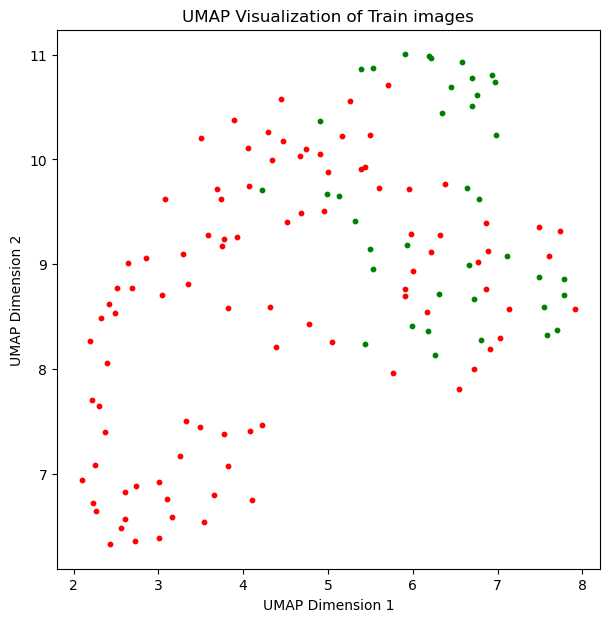

In [12]:
plt.figure(figsize=(7, 7))

plt.scatter(umap_result[[i for i, val in enumerate(labels) if val==0.], 0], 
            umap_result[[i for i, val in enumerate(labels) if val==0.], 1], 
            marker='o', s=10, color="green")

plt.scatter(umap_result[[i for i, val in enumerate(labels) if val==1.], 0], 
            umap_result[[i for i, val in enumerate(labels) if val==1.], 1], 
            marker='o', s=10, color="red")

plt.title('UMAP Visualization of Train images')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [22]:
umap_result.shape, arr.shape

((135, 2), (135, 3))

In [23]:
arr = np.zeros((len(loader), 3))
for i, patient in enumerate(patients):
    arr[i, :] = df_ann[["GENDER", "age", "LYMPH_COUNT"]].loc[df_ann.index == patient].to_numpy()

X_train = np.concatenate((umap_result, arr), axis=1)

In [25]:
X_t, X_val, y_t, y_val = train_test_split(X_train, labels)

In [33]:
# define model
svm_model = SVC(probability=True, kernel='poly')  
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

xgb_model.fit(X_t, y_t)
svm_model.fit(X_t, y_t)

SVC(kernel='poly', probability=True)

In [34]:
y_pred = svm_model.predict(X_val)
accuracy_score(y_val, y_pred)

0.9411764705882353

In [32]:
y_xgb = xgb_model.predict(X_val)
accuracy_score(y_val, y_xgb)

0.8529411764705882

In [36]:
sub_dataset = PatientDataset("./data/testset/", df_ann.LABEL, sub_patients, transform) 
sub_loader = DataLoader(sub_dataset)

In [38]:
dico = {}

for i, data in enumerate(sub_loader):
    # get inputs
    inputs, label, pat = data
    patient = pat[0]

    X = df_ann[df_ann.index == patient].drop("LABEL", axis=1).to_numpy()
    
    inputs = torch.squeeze(inputs, dim=0)

    # compute ae ouptut and flattend
    y = ae.encoder(inputs)
    y_flat = torch.flatten(y, start_dim=1)

    # compute mean, std and max
    # input = torch.mean(y_flat, dim=0).detach().numpy()
    std = torch.std(y_flat, dim=0).detach().numpy()
    max_, _ = torch.max(y_flat, dim=0)
    max_ = max_.detach().numpy()

    conc = np.concatenate((max_, std))
    umap_input = np.array([conc])
    umap_output = umap_model.transform(umap_input)

    svm_input = np.concatenate((umap_output, X), axis=1)

    dico[patient] = svm_model.predict(svm_input)


In [39]:
submission_df = pd.DataFrame()
submission_df["ID"] = dico.keys()
submission_df["predicted"] = dico.values()
submission_df["predicted"] = submission_df.predicted.astype("int")
submission_df = submission_df.set_index("ID")

In [40]:
submission_df.head()

,predicted
ID,
P71,0
P16,1
P114,0
P170,0
P98,0


In [41]:
submission_df.to_csv("./submissions/umap_based_v0.csv")

### SVM on means 

In [55]:
labels_ = [l[0][0] for l in labels]

In [203]:
# define model
svm_model = SVC(probability=True, kernel='linear')  

svm_model.fit(max_sets, labels_)


SVC(kernel='linear', probability=True)

In [112]:
naive_model = GaussianNB()
naive_model.fit(mean_sets, labels_)

GaussianNB()

In [88]:
# perform test
test_labels = df_ann[df_ann.index.isin(test_patients)].LABEL

test_dataset = PatientDataset("./data/trainset/", test_labels, test_patients, transform) 
test_loader = DataLoader(test_dataset)

In [135]:
success = 0
for i, data in enumerate(test_loader):
    # get inputs
    inputs, label, _ = data
    inputs = torch.squeeze(inputs, dim=0)

    # compute ae ouptut and flattend
    y = ae.encoder(inputs)
    y_flat = torch.flatten(y, start_dim=1)

    # compute mean, std and max
    # input = torch.mean(y_flat, dim=0).detach().numpy()
    max_, _ = torch.max(y_flat, dim=0)
    input = max_.detach().numpy()
    input = np.array([input])

    svm_pred = svm_model.predict(input)
    print(svm_pred)
    if svm_pred == label.numpy()[0][0]:
        success += 1

print(success / len(test_loader))

[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
0.7142857142857143


## Naive Bayes

In [67]:
df_ann_train = df_ann[df_ann.index.isin(train_patients)]
df_ann_test = df_ann[df_ann.index.isin(test_patients)]

y_train = df_ann_train.LABEL.to_numpy()
X_train = df_ann_train.drop("LABEL", axis=1).to_numpy()

y_test = df_ann_test.LABEL.to_numpy()
X_test = df_ann_test.drop("LABEL", axis=1).to_numpy()

In [68]:
# Initialize Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

GaussianNB()

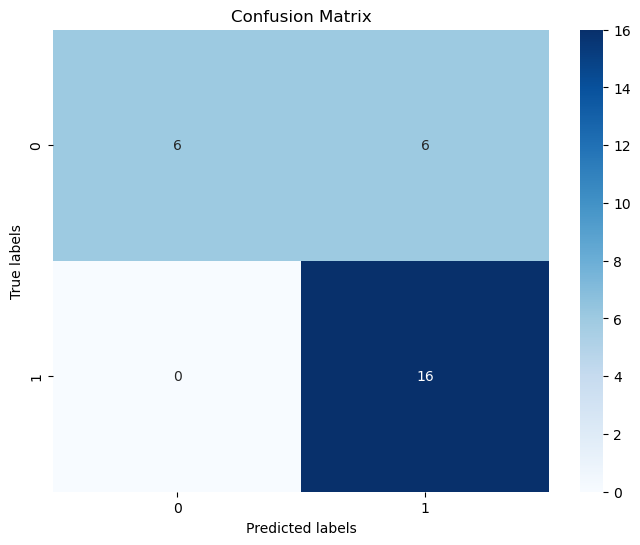

In [74]:
y_pred = nb_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [85]:
y_proba = nb_classifier.predict_proba(X_test)[:, 1]
y_pred, y_proba, y_test

(array([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0], dtype=int64),
 array([9.99744431e-01, 1.00000000e+00, 1.00000000e+00, 5.11248383e-01,
        1.00000000e+00, 7.63447598e-02, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.37681017e-01, 9.99999997e-01, 1.69614081e-01,
        1.00000000e+00, 7.39164531e-02, 5.66746700e-01, 1.00000000e+00,
        1.00000000e+00, 1.92845183e-01, 8.77759345e-01, 2.46493930e-01,
        1.65098417e-01, 1.36690362e-02, 1.00000000e+00, 9.87430871e-01,
        1.21044612e-01, 9.70173252e-05, 6.92627601e-02, 3.30973075e-02]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 1], dtype=int64))

In [208]:
y_pred = []
label_ann = []
label_loader = []

for i, data in enumerate(test_loader):
    # get inputs
    inputs, label, pat = data
    patient = pat[0]
    label_loader.append(label)
    label_ann.append(df_ann[df_ann.index == patient].LABEL.to_numpy())
    X = df_ann[df_ann.index == patient].drop("LABEL", axis=1).to_numpy()
    nb_pred = nb_classifier.predict_proba(X)[0, 1]
 
    inputs = torch.squeeze(inputs, dim=0)

    # compute ae ouptut and flattend
    y = ae.encoder(inputs)
    y_flat = torch.flatten(y, start_dim=1)

    # compute mean, std and max
    # input = torch.mean(y_flat, dim=0).detach().numpy()
    max_, _ = torch.max(y_flat, dim=0)
    input = max_.detach().numpy()
    input = np.array([input])

    svm_pred = svm_model.predict_proba(input)[0, 1]
    y_pred.append(0.5*(svm_pred + nb_pred))


In [216]:
accuracy_score(y_pred >= 0.5, y_test)

0.5714285714285714

In [140]:
sub_dataset = PatientDataset("./data/testset/", df_ann.LABEL, sub_patients, transform) 
sub_loader = DataLoader(sub_dataset)

In [204]:
dico = {}

for i, data in enumerate(sub_loader):
    # get inputs
    inputs, label, pat = data
    patient = pat[0]

    X = df_ann[df_ann.index == patient].drop("LABEL", axis=1).to_numpy()
    nb_pred = nb_classifier.predict_proba(X)
    dico[patient] = nb_pred
    
    inputs = torch.squeeze(inputs, dim=0)

    # compute ae ouptut and flattend
    y = ae.encoder(inputs)
    y_flat = torch.flatten(y, start_dim=1)

    # compute mean, std and max
    # input = torch.mean(y_flat, dim=0).detach().numpy()
    max_, _ = torch.max(y_flat, dim=0)
    input = max_.detach().numpy()
    input = np.array([input])

    dico[patient] += svm_model.predict_proba(input)[0]


In [206]:
dico_patient

NameError: name 'dico_patient' is not defined

In [152]:
submission_df = pd.DataFrame()
submission_df["ID"] = dico.keys()
submission_df["predicted"] = dico.values()
submission_df["predicted"] = submission_df.predicted.astype("int")
submission_df = submission_df.set_index("ID")

In [153]:
submission_df.head()

,predicted
ID,
P71,1
P16,1
P114,1
P170,1
P98,0


In [154]:
submission_df.to_csv("./submissions/ensemble_v0.csv")

In [159]:
df_ann_train[['LYMPH_COUNT', 'age']].to_numpy()


array([[  1.  ,  11.2 ,  91.  ],
       [  1.  ,  12.8 ,  82.  ],
       [  0.  ,  11.6 ,  93.  ],
       [  0.  ,   6.3 ,  27.  ],
       [  0.  , 220.  ,  92.  ],
       [  1.  , 211.  ,  82.  ],
       [  1.  ,   5.3 ,  77.  ],
       [  0.  ,  18.2 ,  89.  ],
       [  1.  , 180.  ,  83.  ],
       [  0.  ,   6.47,  94.  ],
       [  1.  ,  10.1 ,  78.  ],
       [  1.  , 295.  ,  95.  ],
       [  0.  , 130.  ,  72.  ],
       [  1.  ,  31.11,  64.  ],
       [  0.  ,   5.98,  94.  ],
       [  0.  ,  65.93,  91.  ],
       [  0.  ,   9.86,  73.  ],
       [  1.  ,  17.4 ,  66.  ],
       [  1.  ,  39.84,  76.  ],
       [  0.  ,   6.49,  59.  ],
       [  1.  ,   6.41,  72.  ],
       [  1.  ,  24.08,  89.  ],
       [  0.  ,   8.54,  89.  ],
       [  0.  ,  28.4 ,  61.  ],
       [  1.  ,  13.59,  82.  ],
       [  1.  ,  12.43,  70.  ],
       [  1.  , 118.5 ,  61.  ],
       [  1.  ,  11.56,  63.  ],
       [  1.  ,   6.41,  37.  ],
       [  1.  ,   5.29,  81.  ],
       [  

In [200]:
# Initialize UMAP with desired parameters
umap_model = umap.UMAP(min_dist=0.1, metric="manhattan")
tab_data = df_ann_train[['LYMPH_COUNT', 'age']].to_numpy()

concatenated_array = np.concatenate((max_sets, std_sets), axis=1)
# Fit UMAP to your data and transform it to 2D
umap_result = umap_model.fit_transform(concatenated_array)

In [161]:
concatenated_array.shape

(135, 27227)

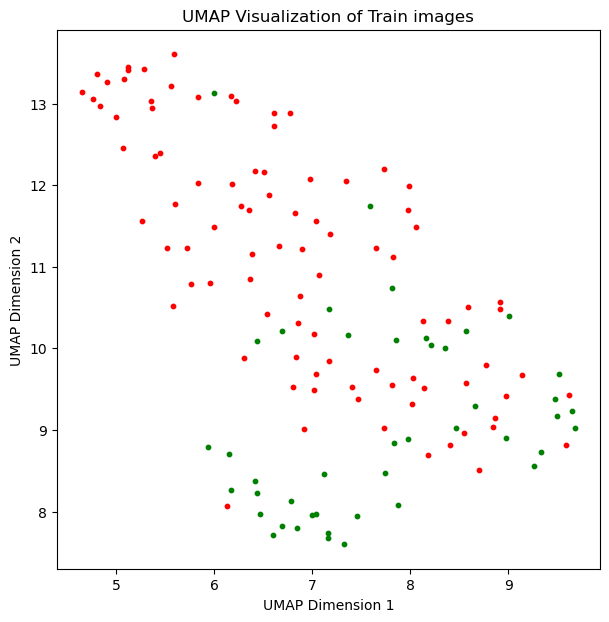

In [201]:
plt.figure(figsize=(7, 7))

plt.scatter(umap_result[[i for i, val in enumerate(labels_) if val==0.], 0], 
            umap_result[[i for i, val in enumerate(labels_) if val==0.], 1], 
            marker='o', s=10, color="green")

plt.scatter(umap_result[[i for i, val in enumerate(labels_) if val==1.], 0], 
            umap_result[[i for i, val in enumerate(labels_) if val==1.], 1], 
            marker='o', s=10, color="red")

plt.title('UMAP Visualization of Train images')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [168]:
from models.DeepSets import DeepSets

In [169]:
deep_model = DeepSets(55*55*3, 128, 1)

In [173]:
data = [(all_flatten_sets[i], labels_[i]) for i in range(len(labels_))]
data = [(torch.tensor(x, dtype=torch.float32), torch.tensor([y], dtype=torch.float32)) for x, y in data]
deep_train_loader = DataLoader(data, shuffle=False)

In [179]:
nb_epochs = 100
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=0.001)

for epoch in range(nb_epochs):
    running_loss = 0.0
    for batch in deep_train_loader:
        inputs, labels = batch
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = deep_model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{nb_epochs}, Loss: {running_loss / len(loader)}")


Epoch 1/100, Loss: 0.6407129452184395
Epoch 2/100, Loss: 0.6315712747750459
Epoch 3/100, Loss: 0.6315562376269588
Epoch 4/100, Loss: 0.631543023718728
Epoch 5/100, Loss: 0.6315314160452948
Epoch 6/100, Loss: 0.6315212426362214
Epoch 7/100, Loss: 0.6315123551421695
Epoch 8/100, Loss: 0.6315046116157814
Epoch 9/100, Loss: 0.6314978661360564
Epoch 10/100, Loss: 0.6314919767556367
Epoch 11/100, Loss: 0.6314868534052813
Epoch 12/100, Loss: 0.6314824038081699
Epoch 13/100, Loss: 0.6314785299477754
Epoch 14/100, Loss: 0.6314751713364213
Epoch 15/100, Loss: 0.6314722447483628
Epoch 16/100, Loss: 0.6314697111094439
Epoch 17/100, Loss: 0.6314675298002032
Epoch 18/100, Loss: 0.631465627529003
Epoch 19/100, Loss: 0.6314639976731053
Epoch 20/100, Loss: 0.6314625793033176
Epoch 21/100, Loss: 0.6314613710950923
Epoch 22/100, Loss: 0.6314603196250068
Epoch 23/100, Loss: 0.6314594279836725
Epoch 24/100, Loss: 0.6314586672517989
Epoch 25/100, Loss: 0.6314580067440315
Epoch 26/100, Loss: 0.63145744381127